# Cantera module for Flamelet Generated Manifolds
## module 1: laminar free flame 
We are going to run a series of free flames, visualise them and create an FGM for ANSYS Fluent. 
As always, go through this interactive notebook in jupyter (jupyter labs or jupyter notebook) and follow the instructions. You can execute the selected cell one by one using the play button at the top or pressing SHIFT+ENTER.
First we load the necessary libraries.
For help on the commands see https://cantera.org/documentation/

In [1]:
%matplotlib inline

matplotlib inline will embed the figures in your notebook document. We will now load some libraries. They are usually pre-installed. If you get an error here, then install the library. 

In [2]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

We are going to compute the solution of a premixed free flame of methane and air, similar to the example on the cantera website

In [3]:
"""
A freely-propagating, premixed methane-air flat flame with unity Lewis transport properties.
"""

# default atmospheric conditions
p = ct.one_atm  # pressure [Pa]
Tin = 300.0  # unburned gas temperature [K]

# numerical parameters
mywidth = 0.03  # total width of the domain in m
myratio = 3     # 
myslope=0.06
mycurve=0.12
#print(flame.get_max_grid_points(1))

# setup parameters
# loglevel = 0 means you will not get any output during the computation
# 1 gives you some output while cantera computes a solution
# >1 gives you a lot of additional output
loglevel = 1  # amount of diagnostic output (0 to 8)

# IdealGasMix object used to compute mixture properties, set to the state of the
# upstream fuel-air mixture
# gri30 is the famous GRI 3.0 mechanism from Berkeley.
gas = ct.Solution('gri30.xml')
print("number of species in the gas = ",gas.n_species)
# note that with the command dir(gas) you can see the content of the gas object (or any other python object)

# set the gas using temperature T, pressure P, mole fractions X
#reactants = 'H2:1.1, O2:1, AR:5'  # premixed gas composition
#gas.TPX = Tin, p, reactants

# set the gas using equivalence ratio, fuel species and air composition
phi = 0.80
fuel_species = 'CH4'
air_composition='O2:0.21,N2:0.79'
gas.set_equivalence_ratio(phi,fuel_species,air_composition)

number of species in the gas =  53


The diffusion model for the species is one of the most complicated models in combustion, together with the model for the chemical reactions. The diffusion model can be very costly and many simplified models are used. The simplest model is to assume a unity Lewis number:

$$ \frac{\lambda}{c_p}=\rho D$$

$$ D = \frac{\lambda}{\rho c_p}$$

In [4]:
# Set up flame object
# create a free flame, allowing for adaptive mesh refinement
flame = ct.FreeFlame(gas, width=mywidth)
flame.set_refine_criteria(ratio=myratio, slope=myslope, curve=mycurve)

# We can print the initial solution
#flame.show_solution()

# Solve with unity lewis number transport model
flame.transport_model = 'UnityLewis'
# solve the equations. This might take 1-2 minutes.
# if you do not want to see any output, put loglevel=0
flame.solve(loglevel=loglevel, refine_grid=True, auto=True)


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.271e-05      4.496
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001095      3.687
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.02806      2.997
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.003329      3.964
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.687e-05       5.88
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001001      5.528
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
grid refinement d

In [5]:
# print the laminar flamespeed, which is the inlet velocity for a free flame
print('laminar flamespeed = {0:7f} m/s'.format(flame.u[0]))
# write the velocity, temperature, density, and mole fractions to a CSV file
#flame.write_csv('ch4_adiabatic_free_phi_080_Le_unity.csv', quiet=False)

laminar flamespeed = 0.247192 m/s


The laminar flame speed $S_L$ is a very important property of the flame. Let's find out if a more accurate diffusion model has any impact on $S_L$

In [6]:
# Set up second flame object for mixture averaged diffusion model
# we make a copy so we can use the solution of the unity lewis approach as initial solution
# create a new free flame, and use the mesh of the previous flame for initialization
flame2 = ct.FreeFlame(gas, grid=flame.grid)
# copy everything to the new flame
flame2=flame

flame2.set_refine_criteria(ratio=myratio, slope=myslope, curve=mycurve)

# Solve with mixture averaged diffusion number transport model
# for details, see e.g. the book of Bird, Stewart and Lightfoot, "Transport Phenomena"
flame2.transport_model = 'Mix'
# solve the equations. This might take 1-2 minutes. 
# Note that we start with the solution of the unity lewis number approach if
flame2.solve(loglevel=loglevel, refine_grid=True, auto=True)


*********** Solving on 168 point grid with energy equation enabled ***********

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.266e-05      6.361
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      6.431
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.703e-05      6.572
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.027e-05      6.521
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.281e-05      6.484
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.849e-05      6.373
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001461      5.627
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.0

In [7]:
# print the laminar flamespeed, which is the inlet velocity for a free flame
print('laminar flamespeed = {0:7f} m/s'.format(flame.u[0]))
# write can write the velocity, temperature, density, and mole fractions to a CSV file
#flame.write_csv('ch4_adiabatic_free_phi_080_Le_unity.csv', quiet=False)

laminar flamespeed = 0.273405 m/s


After obtaining the solution, it is important to check the results with known results from literature. Does the laminar flame speed correspond to literature values? There is some spreading in the experimental data, but we should not be too far off. Which one is better, the value obtained using mixture averaged transport properties or the one using unity Lewis number? Please find experimental data of the laminar flame speed of a methane air flame for different equivalence ratios and plot them, together with the two values that you found, in a single figure

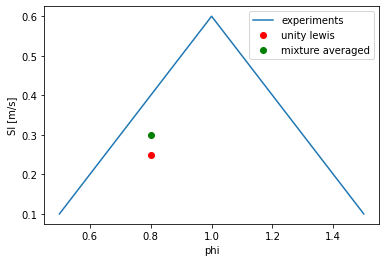

In [8]:
# example figure for comparing simulations with experiments
plt.figure()
phi=[0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
sl=[0.1,0.2,0.3,0.4,0.5,0.6,0.5,0.4,0.3,0.2,0.1]
sl_1 = 0.25
sl_2 = 0.30
plt.plot(phi,sl,label='experiments')
plt.plot(0.80,sl_1,'ro',label='unity lewis')
plt.plot(0.80,sl_2,'go',label='mixture averaged')
plt.xlabel('phi')
plt.ylabel('Sl [m/s]')
plt.legend()
plt.show()

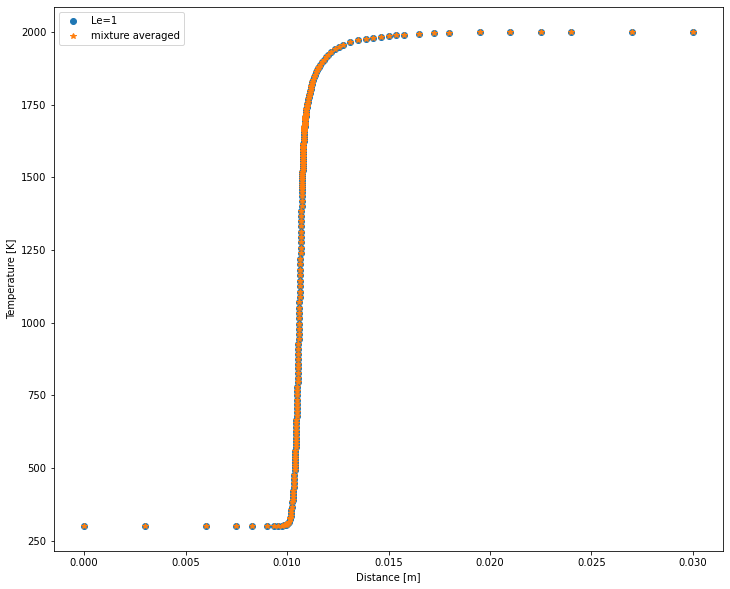

In [10]:
plt.figure()

#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [12, 10]

plt.plot(flame.grid,flame.T,'o',label='Le=1')
plt.plot(flame2.grid,flame2.T,'*',label='mixture averaged')
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [K]');
plt.legend()
plt.draw()

We can see that the redistribution of the grid points places more points in the region of steep gradients. 

In [11]:
# which species are in the the gas?
for i, specie in enumerate(gas.species_names):
    print(str(i) + '. ' + str(specie))

0. H2
1. H
2. O
3. O2
4. OH
5. H2O
6. HO2
7. H2O2
8. C
9. CH
10. CH2
11. CH2(S)
12. CH3
13. CH4
14. CO
15. CO2
16. HCO
17. CH2O
18. CH2OH
19. CH3O
20. CH3OH
21. C2H
22. C2H2
23. C2H3
24. C2H4
25. C2H5
26. C2H6
27. HCCO
28. CH2CO
29. HCCOH
30. N
31. NH
32. NH2
33. NH3
34. NNH
35. NO
36. NO2
37. N2O
38. HNO
39. CN
40. HCN
41. H2CN
42. HCNN
43. HCNO
44. HOCN
45. HNCO
46. NCO
47. N2
48. AR
49. C3H7
50. C3H8
51. CH2CHO
52. CH3CHO


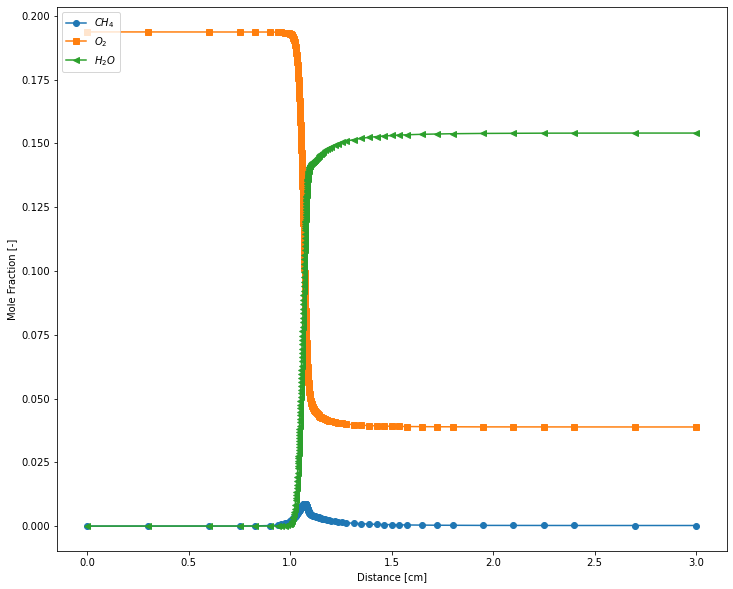

In [12]:
# Extract mole fraction data
X_H2 = flame.X[gas.species_index("H2")]
X_O2 = flame.X[gas.species_index("O2")]
X_H2O = flame.X[gas.species_index("H2O")]

plt.figure()

# we can scale the plot axis to cm and use symbols for plotting
plt.plot(flame.grid*100, X_H2, '-o', label=r'$CH_{4}$')
plt.plot(flame.grid*100, X_O2, '-s', label=r'$O_{2}$')
plt.plot(flame.grid*100, X_H2O, '-<', label=r'$H_{2}O$')

plt.legend(loc=2)
plt.xlabel('Distance [cm]')
plt.ylabel('Mole Fraction [-]');

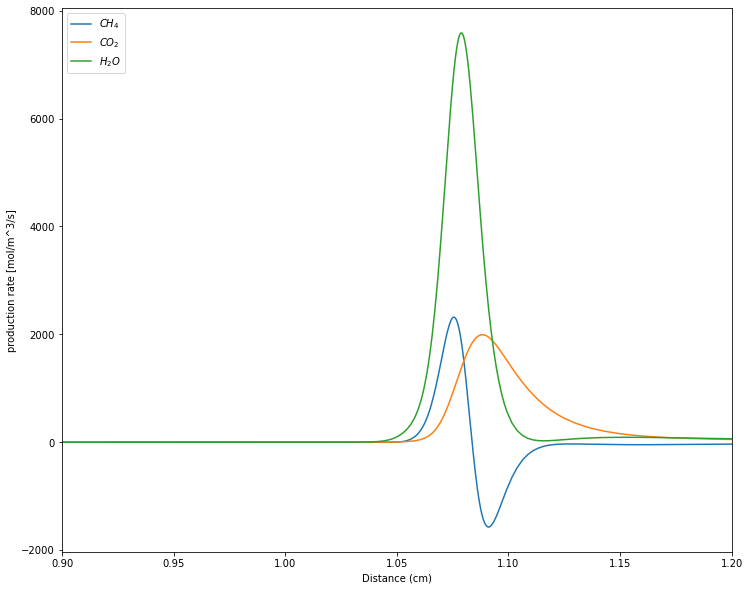

In [14]:
# Extract source term data
S_H2 = flame.net_production_rates[gas.species_index("H2")]
S_CO2 = flame.net_production_rates[gas.species_index("CO2")]
S_H2O = flame.net_production_rates[gas.species_index("H2O")]

plt.figure()

# we can modify the range of the axis.
plt.xlim(0.9,1.2)
plt.plot(flame.grid*100, 1000*S_H2, label=r'$CH_{4}$')
plt.plot(flame.grid*100, 1000*S_CO2, label=r'$CO_{2}$')
plt.plot(flame.grid*100, 1000*S_H2O,label=r'$H_{2}O$')

plt.legend(loc=2)
plt.xlabel('Distance (cm)')
plt.ylabel('production rate [mol/m^3/s]');

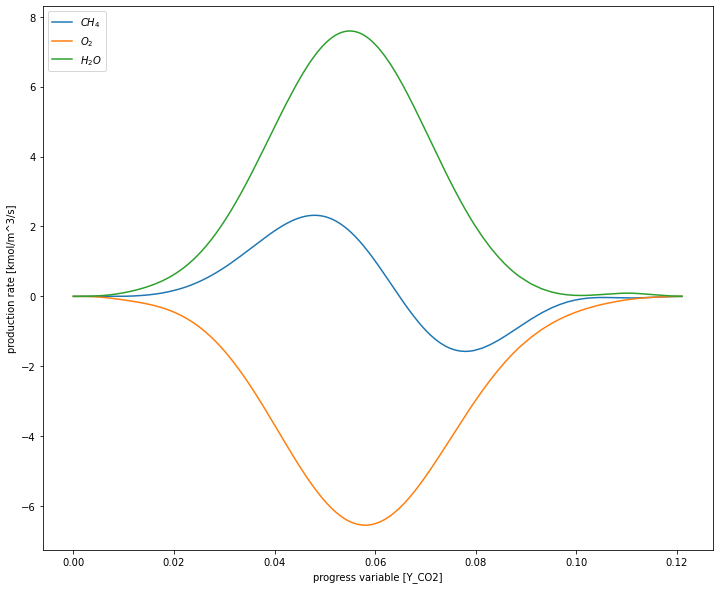

In [18]:
# Extract FGM source term data
Y_CO2 = flame.Y[gas.species_index("CO2")]
S_H2 = flame.net_production_rates[gas.species_index("H2")]
S_O2 = flame.net_production_rates[gas.species_index("O2")]
S_H2O = flame.net_production_rates[gas.species_index("H2O")]

plt.figure()

plt.plot(Y_CO2, S_H2, label=r'$CH_{4}$')
plt.plot(Y_CO2, S_O2, label=r'$O_{2}$')
plt.plot(Y_CO2, S_H2O,label=r'$H_{2}O$')

plt.legend(loc=2)
plt.xlabel('progress variable [Y_CO2]')
plt.ylabel('production rate [kmol/m^3/s]');

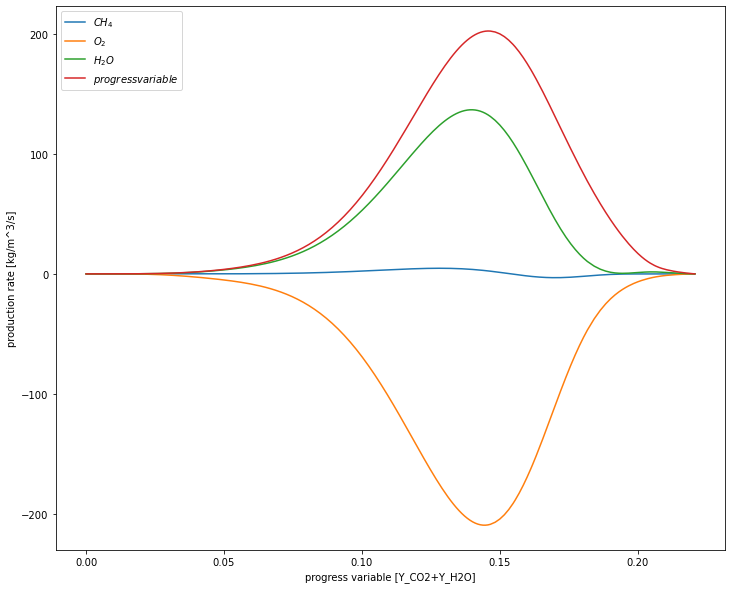

In [19]:
#index to the species
H2 = gas.species_index("H2")
H2O=gas.species_index("H2O")
O2=gas.species_index("O2")
CO2=gas.species_index("CO2")

PROGVAR = flame.Y[CO2] + flame.Y[H2O]

# note that we can convert the production rates from kmol/(m^3s) to kg/(m^3s) using the molecular weight
#gas.molecular_weights (kg/kmol)
S_H2 = gas.molecular_weights[H2]*flame.net_production_rates[H2]
S_O2 = gas.molecular_weights[O2]*flame.net_production_rates[O2]
S_H2O = gas.molecular_weights[H2O]*flame.net_production_rates[H2O]
S_CO2 = gas.molecular_weights[CO2]*flame.net_production_rates[CO2]
S_PROGVAR = S_H2O + S_CO2

plt.figure()

plt.plot(PROGVAR, S_H2, label=r'$CH_{4}$')
plt.plot(PROGVAR, S_O2, label=r'$O_{2}$')
plt.plot(PROGVAR, S_H2O,label=r'$H_{2}O$')
plt.plot(PROGVAR, S_PROGVAR,label=r'$progress variable$')

plt.legend(loc=2)
plt.xlabel('progress variable [Y_CO2+Y_H2O]')
plt.ylabel('production rate [kg/m^3/s]');

Let's investigate the major difference between the unity lewis approach and mixture averaged diffusion. Plot the lewis number of both approaches using the known relationships. How large is the discrepancy?

plot the total enthalpy of both approaches. 

The total enthalpy of the unity lewis number approach should be constant. However, it is not. This is due to the fact that cantera does not use a conserving approach. The enthalpy will become more constant for finer meshes. However, we will assume that the enthalpy has the constant value given at the inlet

We are going to create an FGM for use in Fluent.

First we need to create the header of the file with all the info on the stored data.
Then, we write the FGM data as column data in the ASCII file

In [20]:
# we are going to write the solution as an FGM to a datafile

# definition of progress variable is the mass fraction of CO2
iPV=gas.species_index("CO2")

# points in progress variable direction
pvpoints = len(flame.X[0])
# points in enthalpy direction
enthpoints = 1

strdatasize=str(pvpoints) + " " + str(enthpoints) + " \n"
strgridpower="1.0 1.0 \n"
strpoints=str(pvpoints) + " " + str(enthpoints)
print(strpoints)

fgmheader=["[FGM] \n",
           "2DRLR \n",
           "[DIMENSION] \n",
           "2 \n",
           "[CVDEFINITION] \n",
           "2 \n",
           "CO2  1.0 0.0 \n",
           "ENTHALPY 0.0 1.0 \n",
           "[END] \n",
           "[DATASIZE] \n", 
           strdatasize, 
           "[GRIDPOWER] \n", 
           strgridpower,
           "VARIABLES \n",]

# this is the list of actual variables that we need to add to the database
varlist=["CV1 \n",
         "CV2 \n",
         "SOURCE_CV1 \n",
         "SOURCE_CV2 \n",
         "DIFF_CV1 \n",
         "DIFF_CV2 \n",
         "DENSITY \n",
         "TEMPERATURE \n",
         "CP \n",
         "CONDUCTIVITY \n", 
         "VISCOSITY \n", 
         "HEATRELEASE \n"]

# we can either add all species to the FGM or use a selection. We use a selection
#for i, specie in enumerate(gas.species_names):
#    varlist.append(str(specie)+" \n")

varlist.append("CH4 \n")
varlist.append("CO2")
varlist.append("CO")
varlist.append("H2O")

varlist.append("ENTHALPY \n")
#print(varlist)

# the list of variable is finished

# number of variables
numvar = len(varlist)
#print(numvar)

fgmheader.append(str(numvar)+" \n")
fgmheader = fgmheader + varlist
fgmheader.append("[END] \n")
fgmheader.append("[DATA] \n")

#print(fgmheader)

# now we are going to create the variable that contain the data we want to save in the table

# first control variable: progress variable
CV1=flame.Y[iPV]

# second control variable: enthalpy
ENTHALPY = flame.enthalpy_mass
CV2=ENTHALPY

SOURCE_CV1 = gas.molecular_weights[iPV]*flame.net_production_rates[iPV]
SOURCE_CV2 = 0

# note that for fluent we need the heat capacity in J/(kg.K)
CP=np.array(flame.cp_mass)
# watt/(m.K)
CONDUCTIVITY=np.array(flame.thermal_conductivity)
# kg/m^3
DENSITY=np.array(flame.density)
# mass diffusivity for unity Lewis number means that lambda/cp = rho*D ==> D = lambda/(rho*cp)
DIFF = CONDUCTIVITY/CP
DIFF=DIFF/DENSITY
DIFF_CV1 = DIFF
DIFF_CV2 = DIFF

# the viscosity is in Pa.s = kg/(m.s)
VISCOSITY=flame.viscosity
TEMPERATURE=flame.T
# Watt/m^3
HEATRELEASE=flame.heat_release_rate

# which species do we want to write to the FGM?

SPECIES1 = flame.Y[gas.species_index("CH4")]
SPECIES2 = flame.Y[gas.species_index("CO2")]
SPECIES3 = flame.Y[gas.species_index("CO")]
SPECIES4 = flame.Y[gas.species_index("H2O")]

import csv
# open the file for writing, create if file does not exist, overwrite if file exists
fgmfile = open("fgm.dat","w",newline='')

# write the header
fgmfile.writelines(fgmheader)

# write the data, loop over the enthalpy points
# for i in range
# write the data, loop over the progress variable points
for i in range(0,pvpoints):
    fgmline = [i,CV1[i],CV2[i],SOURCE_CV1[i],SOURCE_CV2,DIFF_CV1[i],DIFF_CV2[i],DENSITY[i],TEMPERATURE[i],CP[i],VISCOSITY[i],HEATRELEASE[i],SPECIES1[i],SPECIES2[i],SPECIES3[i],SPECIES4[i],ENTHALPY[i]]
    #fgmline = [str(item)+' ' for item in fgmlist]
    #fgmline.append("\n")
    #print(fgmline
    #fgmfile.writelines(line)
    wr=csv.writer(fgmfile,delimiter=' ',lineterminator='\n')
    wr.writerow(item for item in fgmline)
    
fgmfile.write("[END]")
fgmfile.close()

192 1


The FGM data has been written to a file. Inspect the file to make sure that the data in the file is correct.